## Emsemble methods and the Titanic Dataset

first we import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import scipy.stats as st

In [57]:
# Unsupervised Models
from sklearn.decomposition import PCA

# Grid
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV

# Supervised Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Evalaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report

# Esemble Voting
from sklearn.ensemble import VotingClassifier

## The Data

Reading in the titanic_train.csv file into a pandas dataframe.

In [4]:
train = pd.read_csv('titanic.csv')

In [5]:
train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Exploratory Data Analysis

We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

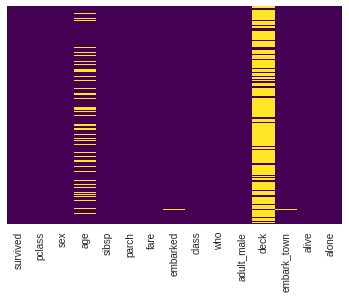

In [6]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, we are missing too much of that data to do something useful with. 

We will first view the survivor ratio to see how imbalanced the data is

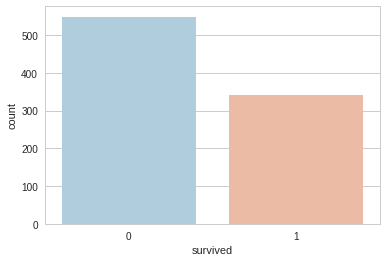

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='survived',data=train,palette='RdBu_r')

Now we will compare survivors by gender

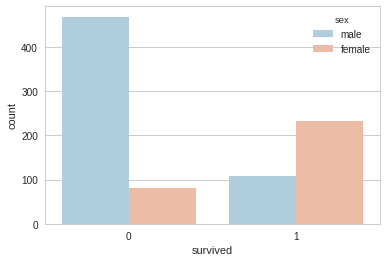

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='survived',hue='sex',data=train,palette='RdBu_r')

Now we will view survivors by class

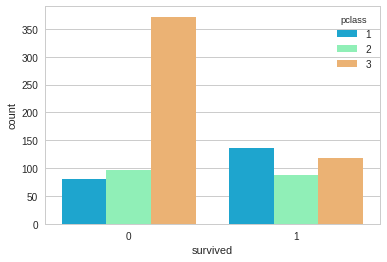

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='survived',hue='pclass',data=train,palette='rainbow')

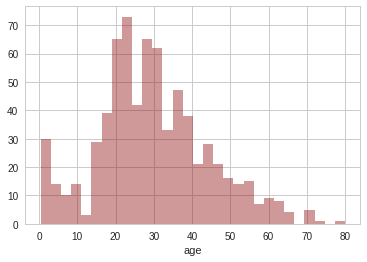

In [10]:
sns.distplot(train['age'].dropna(),kde=False,color='darkred',bins=30)

View of the the distribution of age of passengers

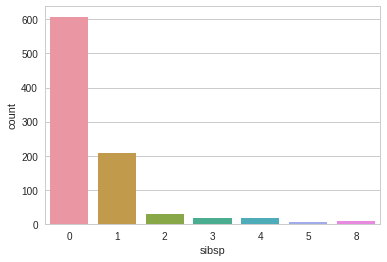

In [12]:
sns.countplot(x='sibsp',data=train)

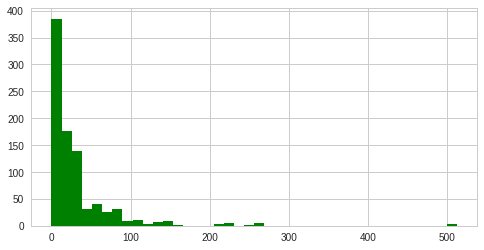

In [13]:
train['fare'].hist(color='green',bins=40,figsize=(8,4))

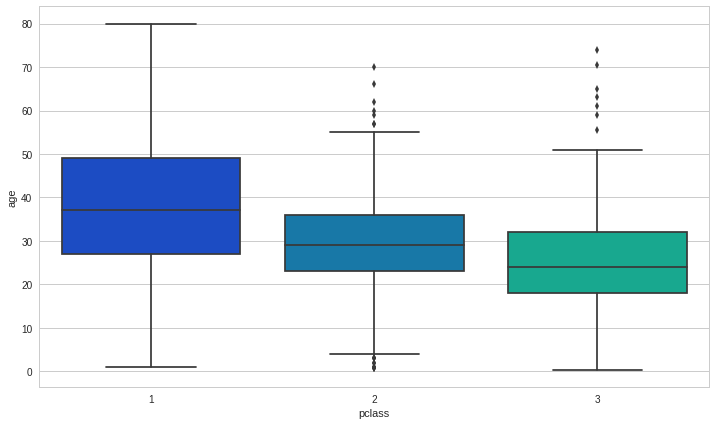

In [14]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='pclass',y='age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [15]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [16]:
train['age'] = train[['age','pclass']].apply(impute_age,axis=1)

Now let's check that heat map again

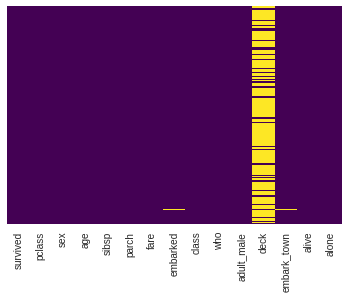

In [17]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great, Let's go ahead and drop the Deck column.

In [18]:
train.drop('deck',axis=1,inplace=True)

In [19]:
train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True


Now we will impute the embarked and embarked_town column with their mode

In [20]:
train['embarked'] = train['embarked'].fillna(train['embarked'].mode().iloc[0])

In [21]:
train['embark_town'] = train['embark_town'].fillna(train['embark_town'].mode().iloc[0])

Now let's check that heat map again to see we have data in all the columns

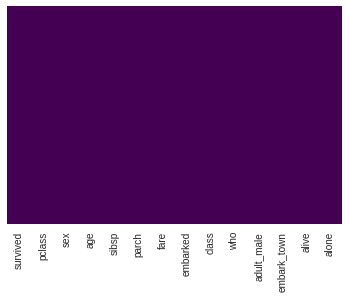

In [22]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

We are going to map the sex column such that female is a one and male is zero

We will also map the embarked column such that Q is 0, S is 1 and C is 2.

In [23]:
train['sex'] = train['sex'].map( {'female': 1, 'male': 0} ).astype(int)
train['embarked'] = train['embarked'].map( {'Q': 0, 'S': 1, 'C': 2} ).astype(int)

We next change the True and False to ones and zeros for the alone and adult_male column

In [24]:
train['alone']=train['alone']*1
train['adult_male']=train['adult_male']*1

In [25]:
train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,0,22.0,1,0,7.2500,1,Third,man,1,Southampton,no,0
1,1,1,1,38.0,1,0,71.2833,2,First,woman,0,Cherbourg,yes,0
2,1,3,1,26.0,0,0,7.9250,1,Third,woman,0,Southampton,yes,1
3,1,1,1,35.0,1,0,53.1000,1,First,woman,0,Southampton,yes,0
4,0,3,0,35.0,0,0,8.0500,1,Third,man,1,Southampton,no,1


We'll next remove class, who, embarked, and alive columns because they are repetitive.  

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null int64
age            891 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       891 non-null int64
class          891 non-null object
who            891 non-null object
adult_male     891 non-null int64
embark_town    891 non-null object
alive          891 non-null object
alone          891 non-null int64
dtypes: float64(2), int64(8), object(4)
memory usage: 97.5+ KB


In [27]:
train.drop(['class','who','embark_town','alive'],axis=1,inplace=True)

In [28]:
train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,adult_male,alone
0,0,3,0,22.0,1,0,7.2500,1,1,0
1,1,1,1,38.0,1,0,71.2833,2,0,0
2,1,3,1,26.0,0,0,7.9250,1,0,1
3,1,1,1,35.0,1,0,53.1000,1,0,0
4,0,3,0,35.0,0,0,8.0500,1,1,1


Now we'll take a heat map of our dataset and see how each feature is correlated 

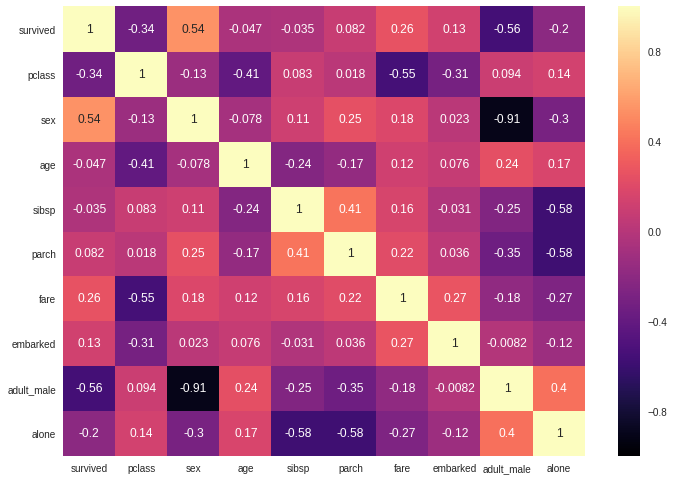

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.heatmap(train.corr(),cmap='magma',annot=True)

In [31]:
X = train.drop(["survived"] , axis=1)
y = train["survived"]
print("Depedent Variable Distribution")
print(y.value_counts(normalize=True)*100)
print("0 = Died", "\n1 = Survived")

Depedent Variable Distribution
0    61.616162
1    38.383838
Name: survived, dtype: float64
0 = Died 
1 = Survived


# PCA
Principal Component Analysis (or PCA) uses linear algebra to transform the dataset into a compressed form.

It is used to explain the variance-covariance structure of a set of variables through linear combinations. It is often used as a dimensionality-reduction technique.

In [32]:
i=4
pca = PCA(n_components=i)
fit = pca.fit(X)

print(("{} Components \nExplained Variance: {}\n").format(i, fit.explained_variance_ratio_))

4 Components 
Explained Variance: [  9.33642733e-01   6.52289307e-02   5.11024199e-04   2.01894657e-04]



# Train/Test Split

We are splitting the data into a training set and a test set.

The splits are stratifies to preserve the ratio of survivors

In [33]:
# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Stratified Cross-Validation
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2)

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 9), (712,), (179, 9), (179,))

## Feature Importance 

Since each split in the decision tree distinguishes the dependent variable, splits closer to the root, aka starting point, have optimally been determined to have the greatest splitting effect. The feature importance graphic measures how much splitting impact each feature has. 

In [35]:
predictors = [x for x in X.columns if x not in ['Survived']]
def feature_imp(model):
    MO = model.fit(X_train, y_train)
    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [36]:
scoring='accuracy'

Creating a results list to store the model parameters and scores stats

Also creating an ensemble dictionary for predicting through an ensemble

In [37]:
results = pd.DataFrame(columns=['Model','Para','Test_Score','CV Mean','CV STDEV'])
ensemble_models= {}

## Model_Save Function 

It gets the best parameters and scores from the classification model and saves them to the results list

Prints the classification report results

In [38]:
def model_save(model, modelname):
    global results
    model.best_estimator_.fit(X_train, y_train)
    scores = cross_val_score(model.best_estimator_, X_train, y_train, cv=10,
                             scoring=scoring, verbose =0)
    
    CV_scores = scores.mean()
    STDev = scores.std()
    Test_scores = model.score(X_test, y_test)

    # CV and Save scores
    results = results.append({'Model': modelname,'Para': model.best_params_,'Test_Score': Test_scores,
                             'CV Mean':CV_scores, 'CV STDEV': STDev}, ignore_index=True)
    ensemble_models[modelname] = model.best_estimator_
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    print(classification_report(y_test,predictions))

# Bootstrap aggregating (AKA Bagging) Decision Trees

Is an ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting.

Creates a bunch of trees using a subset of the the data for each, while using sampling without replacement

In [39]:
# Parameter Tuning
param_grid ={'n_estimators': st.randint(200, 800)}

tree = DecisionTreeClassifier()
grid = RandomizedSearchCV(BaggingClassifier(tree),
                    param_grid, cv=cv, scoring=scoring,
                    verbose=1,n_iter=50)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  8.4min finished


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
        ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2dae361b38>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=1)

In [40]:
model_save(grid, "Bagger_ensemble")

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  8.6min finished


             precision    recall  f1-score   support

          0       0.82      0.90      0.86       110
          1       0.81      0.70      0.75        69

avg / total       0.82      0.82      0.82       179



# Random Forest Classifier 

An emsemble method that builds upon Bootstrap Aggregation method by adding a random feature selection dimension. More uncorrelated splits, less overemphasis on certain features. It forces the model to give a large role to less dominant features, leading to a better generalizing model. 

Mean CV Accuracy: 0.822346368715


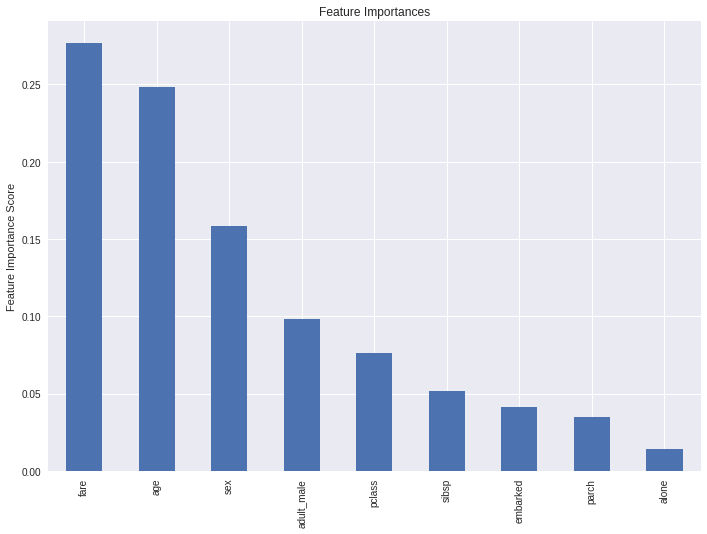

In [41]:
model = RandomForestClassifier()
print("Mean CV Accuracy:",cross_val_score(model, X, y, cv=cv, scoring=scoring).mean())
feature_imp(model)

In [42]:
# Parameter Tuning
param_grid ={'max_depth': st.randint(6, 11),
             'n_estimators': st.randint(200, 800),
             'max_features':np.arange(0.5,.81, 0.05),
            'max_leaf_nodes':st.randint(6, 10)}


grid = RandomizedSearchCV(model,
                    param_grid, cv=cv, scoring=scoring,
                    verbose=1,n_iter=50)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  6.8min finished


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2dae1d56a0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2dae1d5668>, 'max_features': array([ 0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ]), 'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2dae1d5ef0>},
          pre_disp

In [43]:
model_save(grid, "Random_Forest")

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  7.4min finished


             precision    recall  f1-score   support

          0       0.81      0.95      0.87       110
          1       0.88      0.64      0.74        69

avg / total       0.83      0.83      0.82       179



# Adaptive Boosting

Applies weights to all data points and optimizes them using the loss function. Fixes mistakes by assigning high weights to them during iterative process.

Iterates through multiple models in order to determine the best boundaries. It relies on using weak models to determine the pattern, and eventually creates a strong combination of them.

In [44]:
# Parameter Tuning
param_grid ={'n_estimators':st.randint(200, 800),
            'learning_rate':np.arange(.1, 4, .5)}

grid = RandomizedSearchCV(AdaBoostClassifier(),
                    param_grid,cv=cv, scoring=scoring,
                    verbose=1, n_iter=50)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  8.8min finished


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params={}, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2dae1c6208>, 'learning_rate': array([ 0.1,  0.6,  1.1,  1.6,  2.1,  2.6,  3.1,  3.6])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=1)

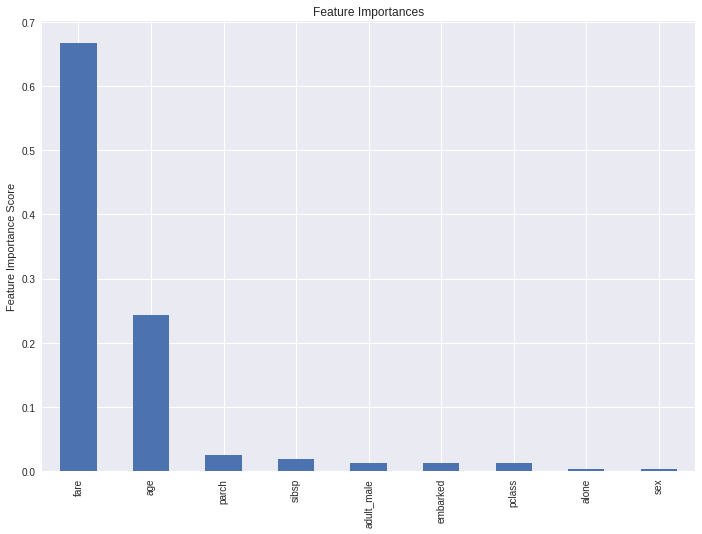

In [45]:
feature_imp(grid.best_estimator_)

In [46]:
model_save(grid, "AdaBoost_Ensemble")

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  7.9min finished


             precision    recall  f1-score   support

          0       0.83      0.85      0.84       110
          1       0.76      0.72      0.74        69

avg / total       0.80      0.80      0.80       179



# Gradient Boosting

Produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

In [47]:
# Parameter Tuning
param_grid ={'n_estimators': st.randint(200, 800),
            'loss': ['deviance', 'exponential'],
            'learning_rate':np.arange(0.01, 0.32,.05),
            'max_depth': np.arange(2, 4.1, .5)}

grid = RandomizedSearchCV(GradientBoostingClassifier(),
                    param_grid,cv=cv,
                    scoring=scoring,
                    verbose=1, n_iter=50)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.4min finished


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2dae0e72b0>, 'loss': ['deviance', 'exponential'], 'learning_rate': array([ 0.01,  0.06,  0.11,  0.16,  0.21,  0.26,  0.31]), 'max_depth': array([ 2. ,  2.5,  3. ,  3.5,  4. ])},
          pre_dispatch='2*n_jobs', random_state=None, r

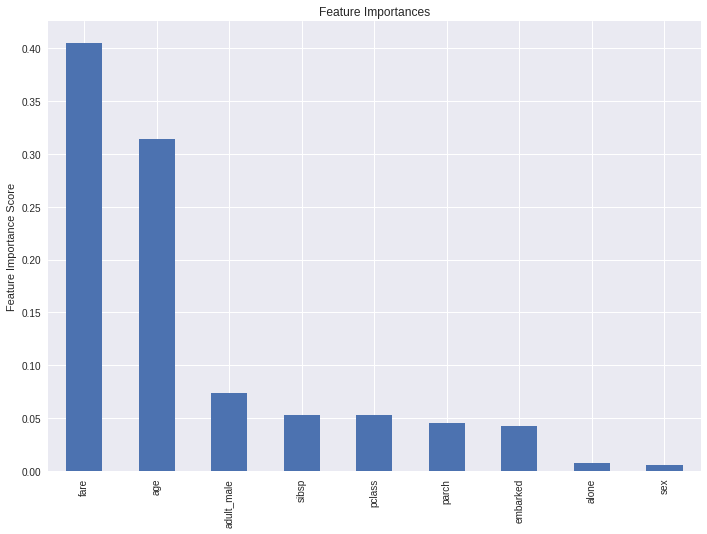

In [48]:
feature_imp(grid.best_estimator_)

In [49]:
model_save(grid, "Gradient_Boosting")

Fitting 10 folds for each of 50 candidates, totalling 500 fits
             precision    recall  f1-score   support

          0       0.80      0.92      0.85       110
          1       0.83      0.62      0.71        69

avg / total       0.81      0.80      0.80       179



[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.2min finished


In [50]:
results

,Model,Para,Test_Score,CV Mean,CV STDEV
0,Bagger_ensemble,{'n_estimators': 563},0.821229,0.804666,0.031117
1,Random_Forest,"{'max_depth': 8, 'max_features': 0.8, 'max_lea...",0.826816,0.823018,0.028992
2,AdaBoost_Ensemble,"{'learning_rate': 1.1, 'n_estimators': 316}",0.787709,0.802087,0.033976
3,Gradient_Boosting,"{'learning_rate': 0.06, 'loss': 'exponential',...",0.815642,0.820201,0.046236


# Model Summary

Out of the 4 emsemble methods we produced the best accuracy with the Random Forest in both the cross validated 10 fold training model and the test set.

Next we will create an emsemble classifier from our four model to see if together we can improve their accuracy. 

In [52]:
prob_models = results

In [88]:
classifier_tuples=[]
for i in range(len(ensemble_models)):
    tup=(list(ensemble_models.keys())[i],list(ensemble_models.values())[i])
    classifier_tuples.append(tup)

In [101]:
#soft 
ECS = VotingClassifier(estimators=classifier_tuples, voting='soft', weights=[1,1,1,1])
ECS.fit(X_train, y_train)

predictions = model.predict(X_test)
    
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.82      0.91      0.86       110
          1       0.82      0.68      0.75        69

avg / total       0.82      0.82      0.82       179



Using the emsemble method we did not see an improvement in performance.

# Receiver Operating Characteristic curve [ROC]

ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

If the dataset is imbalanced and the minority class is of interest, it is better to use [AUC] Area Under the Curve than accuracy or rmse, since those metrics can get away with assigning the majority class to all, and still get away with high accuracy.

In [113]:
pd.options.display.max_seq_items = 5000

10-fold cross validation:

Train CV Accuracy: 0.81 (+/- 0.03) [Bagger_ensemble]
ROC AUC: 0.9
Test Accuracy: 0.82 

Train CV Accuracy: 0.83 (+/- 0.01) [Random_Forest]
ROC AUC: 0.88
Test Accuracy: 0.83 

Train CV Accuracy: 0.79 (+/- 0.02) [AdaBoost_Ensemble]
ROC AUC: 0.85
Test Accuracy: 0.79 

Train CV Accuracy: 0.82 (+/- 0.02) [Gradient_Boosting]
ROC AUC: 0.86
Test Accuracy: 0.82 



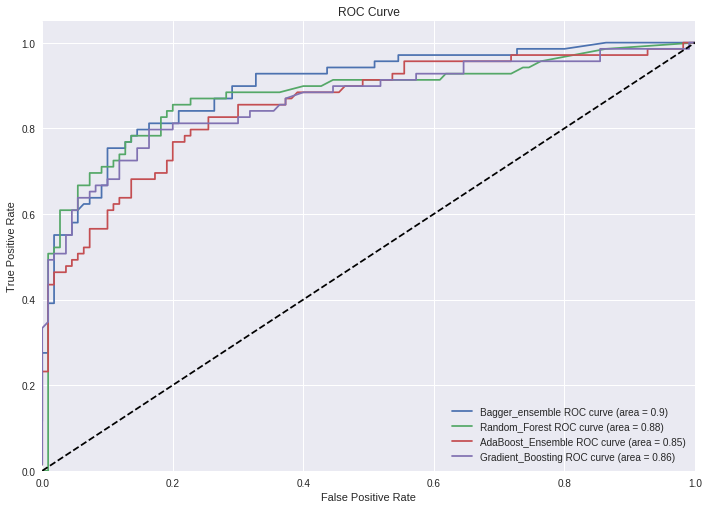

In [116]:
#Probabilistic
models = list(zip([ensemble_models[x] for x in prob_models.Model],
                  prob_models.Model))
plt.figure()

print('10-fold cross validation:\n')
clfs = []
for clf, label in models:
    scores = cross_val_score(clf, X_train, y_train,cv=cv, scoring=scoring, verbose=0)
    print("Train CV Accuracy: {} (+/- {}) [{}]".format(round(scores.mean(),2), round(scores.std(),2), label))
    md = clf.fit(X_train, y_train)
    # Add to Roc Curve
    fpr, tpr, _ = roc_curve(y_test, md.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)

    print('ROC AUC: {}'.format(round(roc_auc,2)))
    plt.plot(fpr, tpr, label='{} ROC curve (area = {:.2})'.format(label, roc_auc))
    
    clfs.append(md)
    print("Test Accuracy: {} \n".format(round(metrics.accuracy_score(clf.predict(X_test), y_test),2)))
    
# Plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Conclusion 

Emsemble methods are powerful classifiers.  Measuring accurcies we found that the Random Forest classfier performed best; however, becasue the dataset is imbalanced and it is best to use AUC as a performance meteric the Bagger Emsemble model won out.  